# Advanced Machine Learning - programming assignment 4

*Due: Friday January 24*

*Grading: 10 points total*

**Please fill in:**
* Juan David Liut Aymar - 3478092
* Alexia Ntantouri - 2958481

### Further instructions:
* Code quality is considered during the assessment. Use sensible variable names, and make sure your code is properly commented.
* Submit your code in Blackboard using one of your accounts; we will put the grade in Blackboard for the other team member as well.
* Make sure to name the submitted file according to your and your collaborators last name. (`submitter_collaborator.ipynb`)
* **Failure to follow these instructions can affect the assignment grade.**

## Implementing the PC algorithm
In this assignment, you will complete an implementation of the PC algorithm. After that, you will use it to discover causal relations in a data set. Each of these two parts is worth 5 points.

The PC algorithm will need to keep track of a PDAG. We will represent this PDAG by a numpy array `G` of booleans.

The matrix `G` represents a graph as follows:
* For all `x`, `G[x,x] == False`
* `G[x,y] == False` and `G[y,x] == False` means: no edge between x and y
* `G[x,y] == True` and `G[y,x] == True` means: an undirected edge x&mdash;y
* `G[x,y] == True` and `G[y,x] == False`means: a directed edge x$\to$y

In [1]:
import numpy as np
import itertools
import graphviz

from AML_assignment4_util import *

We use `graphviz` to save graphs to different file formats, or show them directly in the notebook. The function `graph_to_graphviz(G, node_names)` (from the file `AML_assignment4_util.py`) converts a numpy array of the form described above to a graph in graphviz format. It requires the `Graphviz` program to be installed: see the instructions on Blackboard.

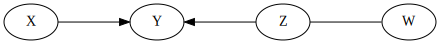

In [2]:
# Demonstration of graph_to_graphviz:
node_names = ['X', 'Y', 'Z', 'W']
G1 = np.zeros((4,4), dtype=bool)
G1[0,1] = G1[2,1] = True # two directed edges
G1[2,3] = G1[3,2] = True # an undirected edge
d = graph_to_graphviz(G1, node_names)
d # must be final line of code block to be displayed

Here is a Python class for performing the PC algorithm (when an object of this class is created and its `run` function is called). Add the missing code for phase 2, and implement phases 3 and 4. Do not modify other code! In the next section, you'll find some test cases to see if your code runs without errors and does what you expect it to.

In [3]:
class PC_algorithm:
    def __init__(self, independence_tester, verbose=1):
        # verbose can be 0 (silent), 1 (report independences), or 2 (also report dependences)
        self.independence_tester = independence_tester
        self.n = independence_tester.n_observed
        self.node_names = independence_tester.node_names
        self.verbose = verbose
        self.G = np.logical_not(np.eye(self.n, dtype=bool))
        self.sepset = dict()

    def skeleton_search(self):
        # PHASE II: Skeleton search
        # Note: Adj(X) in the slides means: all nodes adjacent to X in the current graph G
        for k in range(self.n-1):
            for x in range(self.n):
                for y in range(self.n):
                    if not self.G[x,y]:
                        continue
                    # Try all subsets S of Adj(x) \ {y} with |S|=k.
                    # Hint: use itertools.combinations

                    # TASK 1: Your code here (1 point)

                    # Try all subsets S of Adj(x) \ {y} with |S| = k
                    adj_x = np.where(self.G[x])[0]
                    adj_x = adj_x[adj_x != y]  # Exclude y

                    if len(adj_x) < k:
                        continue

                    for S in itertools.combinations(adj_x, k):
                        indep = self.independence_tester.test_independence(x, y, S)
                        if indep:
                            if self.verbose >= 1:
                                print(f"independence found: "
                                      f"{self.node_names[x]} and {self.node_names[y]} "
                                      f"given {{{', '.join([self.node_names[v] for v in S])}}}")
                            # Remove this edge.
                            self.G[x,y] = self.G[y,x] = False
                            # We use frozensets as keys in the dictionary self.sepset,
                            # because ordinary sets can't be used as keys to dictionaries.
                            self.sepset[frozenset([x,y])] = S
                            break
                        else:
                            if self.verbose >= 2:
                                print(f"dependence found: "
                                      f"{self.node_names[x]} and {self.node_names[y]} "
                                      f"given {{{', '.join([self.node_names[v] for v in S])}}}")

            # Do we need to continue with larger k?
            max_S_size = np.sum(self.G, axis=0) - 1
            if np.all(max_S_size < k + 1):
                break
        return

    def orient_v_structures(self):
        # PHASE III: Orient v-structures

        # Something to watch out for:
        # If the data are not faithful to any DAG, the algorithm may end up trying
        # to orient a single edge in two different ways. You can choose either
        # orientation if this happens. But make sure not to accidentally delete such an edge!

        # TASK 2: Your code here (2 points)

        for z in range(self.n):  # Loop through each node Z in the graph.

          # Find all pairs of nodes (X, Y) that are adjacent to Z (potential parents of Z).
            for x, y in itertools.combinations(np.where(self.G[:, z])[0], 2):

                # Check if X and Y are NOT directly connected (no edge between them).
                if not self.G[x, y] and not self.G[y, x]: # x and y are not adjacent

                    # Check if Z is NOT in the separating set of X and Y.
                    if frozenset([x, y]) in self.sepset and z not in self.sepset[frozenset([x, y])]:

                        # Orient edges: X -> Z and Y -> Z
                        self.G[x, z] = True  # Create a directed edge X -> Z
                        self.G[z, x] = False  # Remove any possibility of Z -> X
                        self.G[y, z] = True  # Create a directed edge Y -> Z
                        self.G[z, y] = False  # Remove any possibility of Z -> Y

                        # Log the orientation if verbosity is enabled.
                        if self.verbose >= 1:
                            print(f"v-structure oriented: "
                                  f"{self.node_names[x]} → {self.node_names[z]} ← {self.node_names[y]}")
        return

    def orientation_rules(self):
        # PHASE IV: Orientation rules

        # TASK 3: Your code here (2 points)

        while True:
            changes = False

            # Rule 2: If A -> B, B and C are adjacent, A and C are not adjacent, and there is no arrowhead at B,
            # then orient B - C as B -> C.
            for a, b in itertools.permutations(range(self.n), 2):  # Iterate over all pairs (A, B)
                if self.G[a, b] and not self.G[b, a]:  # Check if A -> B (directed edge from A to B)
                    for c in np.where(self.G[b])[0]:  # Find all nodes C that are adjacent to B
                        if self.G[b, c] and self.G[c, b] and not self.G[a, c] and not self.G[c, a]:  # B - C is undirected (both edges exist) and A and C are not adjacent
                            # Orient the edge B - C as B -> C
                            self.G[b, c] = True  # Create a directed edge B -> C
                            self.G[c, b] = False  # Remove the reverse edge C -> B
                            changes = True
                            if self.verbose >= 1:
                                print(f"edge oriented: {self.node_names[b]} → {self.node_names[c]} (Rule 2)")

            # Rule 3: If there is a directed path from A to B, and an edge between A and B,
            # then orient A — B as A -> B.
            for a, b in itertools.combinations(range(self.n), 2):  # Iterate over all pairs (A, B)
                if self.G[a, b] and self.G[b, a]:  # Check for undirected edge A — B
                    for z in range(self.n):  # Check for a directed path A -> Z -> B
                        # If we find a node Z such that:
                        #   - There's a directed edge from A to Z (A -> Z)
                        #   - There's a directed edge from Z to B (Z -> B)
                        #   - There's no edge from Z to A (no reverse edge for A -> Z)
                        #   - There's no edge from B to Z (no reverse edge for Z -> B)
                        # Then we have a directed path from A to B
                        if self.G[a, z] and self.G[z, b] and not self.G[z, a] and not self.G[b, z]:
                            self.G[b, a] = False  # Orient A — B as A -> B by removing the reverse direction (B -> A).
                            changes = True
                            if self.verbose >= 1:
                                print(f"Rule 3 applied: {self.node_names[a]} → {self.node_names[b]}")

            # Rule 4: If A -> B <- C, A - D - C, A and C are not adjacent, and D - B, then orient D - B as D -> B.
            for a, b, c, d in itertools.permutations(range(self.n), 4):
                if (
                    # A -> B and C -> B (v-structure at B)
                    self.G[a, b] and not self.G[b, a] and
                    self.G[c, b] and not self.G[b, c] and

                    # A and C are not adjacent
                    not self.G[a, c] and not self.G[c, a] and

                    # A - D and D - C (undirected edges)
                    self.G[a, d] and self.G[d, a] and
                    self.G[d, c] and self.G[c, d] and

                    # D - B (undirected edge between D and B)
                    self.G[d, b] and self.G[b, d]
                ):
                    self.G[b, d] = False  # Orient D - B as D -> B by removing the reverse edge B -> D.
                    changes = True
                    if self.verbose >= 1:
                        print(f"edge oriented: {self.node_names[d]} → {self.node_names[b]} (Rule 4)")

            if not changes:
                break

        return

    def run(self):
        # The initialization step has already been performed by the __init__ method.
        # Perform the other phases one by one. Each of the following functions
        # modifies self.G, which represents the graph.
        self.skeleton_search()
        self.orient_v_structures()
        self.orientation_rules()

        return self.G

## Testing the PC implementation

To verify that the algorithm is working correctly, we will feed it output from an *oracle* instead of conditional independence test results from a data set. The oracle knows what the true DAG is, and mimics the conditional independence test results that we would get for data that is Markov and faithful to that DAG. In this situation, the PC algorithm will recover the Markov equivalence class of the true DAG.

In [4]:
class IndependenceOracle:
    def __init__(self, true_G, node_names, n_observed=None):
        self.G = true_G
        self.n = true_G.shape[0]
        self.n_observed = n_observed if n_observed is not None else self.n
        self.node_names = node_names
    def test_independence(self, x, y, S):
        S_mask = np.zeros(self.n, dtype=bool)
        np.put(S_mask, S, True)
        return is_d_separated(self.G, x, y, S_mask)

We will compare the output of PC to the oracle's true DAG for the DAG `G1` we saw before, and for several other DAGs. (You can add more tests to help chase down any bugs.)

dependence found: X and Y given {}
independence found: X and Z given {}
independence found: X and W given {}
dependence found: Y and X given {}
dependence found: Y and Z given {}
dependence found: Y and W given {}
dependence found: Z and Y given {}
dependence found: Z and W given {}
dependence found: W and Y given {}
dependence found: W and Z given {}
dependence found: Y and X given {Z}
dependence found: Y and X given {W}
dependence found: Y and Z given {X}
dependence found: Y and Z given {W}
dependence found: Y and W given {X}
independence found: Y and W given {Z}
dependence found: Z and Y given {W}
dependence found: Z and W given {Y}
v-structure oriented: X → Y ← Z
PASS


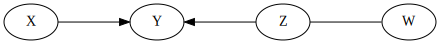

In [5]:
oracle = IndependenceOracle(G1, node_names)
A = PC_algorithm(oracle, verbose=2)
G = A.run()
print("PASS" if np.all(G == G1) else "FAIL")
graph_to_graphviz(G, oracle.node_names)

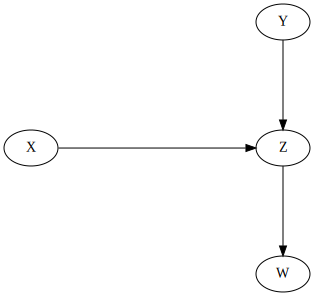

In [6]:
G2 = np.zeros((4,4), dtype=bool)
G2[0,2] = G2[1,2] = G2[2,3] = True
graph_to_graphviz(G2, node_names)

independence found: X and Y given {}
independence found: X and W given {Z}
independence found: Y and W given {Z}
v-structure oriented: X → Z ← Y
edge oriented: Z → W (Rule 2)
PASS


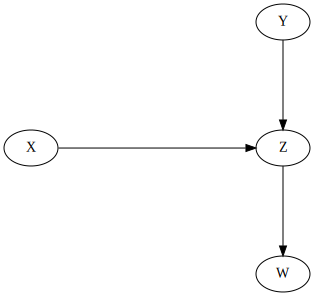

In [7]:
oracle = IndependenceOracle(G2, node_names)
A = PC_algorithm(oracle)
G = A.run()
print("PASS" if np.all(G == G2) else "FAIL")
graph_to_graphviz(G, oracle.node_names)

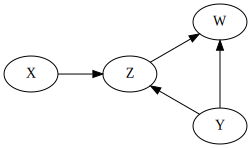

In [8]:
G3 = np.zeros((4,4), dtype=bool)
G3[0,2] = G3[1,2] = G3[1,3] = G3[2,3] = True
graph_to_graphviz(G3, node_names)

independence found: X and Y given {}
independence found: W and X given {Y, Z}
v-structure oriented: X → Z ← Y
edge oriented: Z → W (Rule 2)
Rule 3 applied: Y → W
PASS


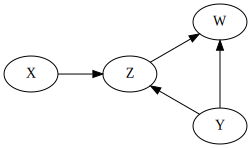

In [9]:
oracle = IndependenceOracle(G3, node_names)
A = PC_algorithm(oracle)
G = A.run()
print("PASS" if np.all(G == G3) else "FAIL")
graph_to_graphviz(G, oracle.node_names)

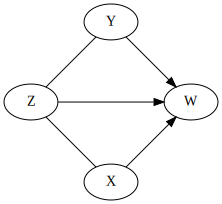

In [10]:
G4 = np.logical_not(np.eye(4, dtype=bool))
G4[0,1] = G4[1,0] = False
G4[3,0] = G4[3,1] = G4[3,2] = False
graph_to_graphviz(G4, node_names)

independence found: X and Y given {Z}
v-structure oriented: X → W ← Y
edge oriented: Z → W (Rule 4)
PASS


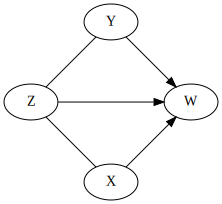

In [11]:
oracle = IndependenceOracle(G4, node_names)
A = PC_algorithm(oracle)
G = A.run()
print("PASS" if np.all(G == G4) else "FAIL")
graph_to_graphviz(G, oracle.node_names)

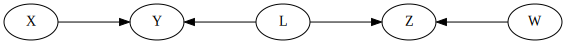

In [12]:
# Example of a case for which no DAG exists that is Markov and faithful to the distribution.
# L is a latent variable that the PC algorithm won't know about. PC's output should be either
# X --> Y --> Z <-- W or
# X --> Y <-- Z <-- W.
# If there is no edge between Y and Z in your output, this most likely indicates a bug in
# your implementation of phase III.
G5 = np.zeros((5,5), dtype=bool)
G5[0,1] = G5[4,1] = True
G5[3,2] = G5[4,2] = True
graph_to_graphviz(G5, ['X', 'Y', 'Z', 'W', 'L'])

independence found: X and Z given {}
independence found: X and W given {}
independence found: Y and W given {}
v-structure oriented: X → Y ← Z
PASS


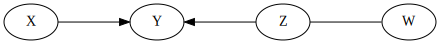

In [13]:
oracle = IndependenceOracle(G5, node_names, n_observed = 4)
A = PC_algorithm(oracle)
G = A.run()
print("PASS" if G[0,1] and G[3,2] and (G[1,2] or G[2,1]) and np.sum(np.logical_or(G, G.T)) == 6 else "FAIL")
graph_to_graphviz(G, oracle.node_names)

## Running PC on data
In this second part of the assignment, you will apply the PC algorithm to the biological dataset of Sachs et al. (2005). In this dataset, the columns represent 11 different proteins, which were measured in thousands of human immune system cells. Each row is a single cell. The cells were prepared in different ways, by adding different chemicals some time before the measurements were made. A twelfth column, labeled `experiment`, indicates in which way that cell was prepared. We can think of `experiment=1` as denoting the observational data, and other values of `experiment` (2 through 14) as various interventional datasets.

In [14]:
import pandas as pd

all_data = pd.read_csv("sachs2005_combined.csv", sep='\t')
# Transform all columns except 'experiment' by taking the logarithm of 10 + the original value
all_data.loc[:, all_data.columns != 'experiment'] = np.log(10 + all_data.loc[:, all_data.columns != 'experiment'])

We will apply the PC algorithm to just the observational data.

Make a new dataframe containing only the data where experiment equals 1. Remove the `experiment` column from this dataframe. Check the shape of your dataframe: it should be `(853, 11)`.

In [15]:
# TASK 4: Your code here (0.5 point)
import numpy as np

# Select only the observational data (experiment=1)
observational_data = all_data[all_data['experiment'] == 1]

# Remove the 'experiment' column
observational_data = observational_data.drop('experiment', axis=1)

# Check the shape of the dataframe
print(observational_data.shape)  # Output: (853, 11)

(853, 11)


To run the PC algorithm on data, we need to perform (conditional) independence tests. The code below implements a simple test (based on [Spearman correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)). It is not a perfect match for our data, but the alternatives (such as `CMIknn` (Runge, 2018)) are orders of magnitude slower, while Spearman correlation usually already gives decent results.

As a statistical test, a conditional independence test works by computing a p-value. If a conditional independence exists, this p-value will be approximately uniformly distributed on the interval between 0 and 1. If the variables being tested are conditionally dependent, the p-value will be close to 0. PC wants to know a binary answer, so we will pick some threshold alpha and declare an independence if the p-value is larger than alpha.

In statistical testing, alpha is often taken to be 0.05 or smaller. For PC, it may be more appropriate to pick a larger alpha instead. This is because as soon as PC finds a (conditional) independence between two variables, it will delete the edge between them and do no more tests between those two variables. If this happens while it shouldn't have, PC can't put the edge back. But in the reverse situation, if PC leaves an edge in place while it should have deleted it, there is still a possibility that the edge will be deleted later, when another test between those two variables reports a more convincing independence.

In [16]:
import math
from scipy.stats import beta

class IndependenceTester:
    def __init__(self, data, alpha, verbose=2, method='spearman', n_observed=None):
        # data: a pandas dataframe
        # alpha: the significance level to which the p-values are compared

        self.covariance_matrix = data.corr(method).to_numpy()
        self.num_samples = data.shape[0]
        self.n = data.shape[1]
        self.n_observed = n_observed if n_observed is not None else self.n
        self.verbose = verbose
        self.node_names = data.columns
        self.alpha = alpha
    def test_independence(self, x, y, S):
        # Compute the partial correlation of x and y given S by inverting a submatrix of the covariance matrix.
        xyS = [x, y]
        xyS.extend(S)
        precision_matrix = np.linalg.inv(self.covariance_matrix[np.ix_(xyS, xyS)])
        corr = -precision_matrix[0,1] / math.sqrt(precision_matrix[0,0] * precision_matrix[1,1])
        # Compute the p-value as in the scipy manual for scipy.stats.pearsonr.
        dist = beta(self.num_samples / 2 - 1, self.num_samples / 2 - 1, loc=-1, scale=2)
        pval = 2 * dist.cdf(-abs(corr))
        test_result = pval > self.alpha
        if self.verbose >= 2 or (self.verbose >= 1 and test_result):
            print(f"test: {self.node_names[x]} and {self.node_names[y]} "
                  f"given {{{', '.join([self.node_names[v] for v in S])}}} "
                  f"-> pval={pval}")
        return test_result

Using an IndependenceTester object (which works similarly to the IndependenceOracle we used earlier), run the PC algorithm on the observational data. Display the graph that comes out. You may experiment with different values of alpha; the graph you get should either be connected (i.e. consist of one [connected component](https://en.wikipedia.org/wiki/Component_%28graph_theory%29)), or have just two or three connected components.

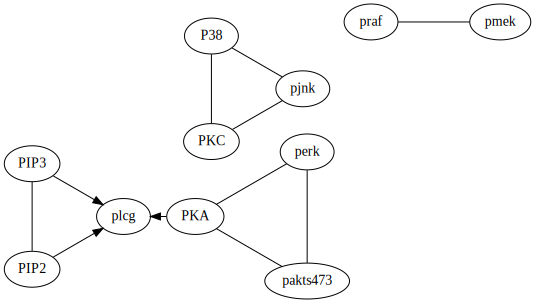

In [17]:
# TASK 5: Your code here (1 point)

# Running the PC algorithm on the observational data

# Set a value for alpha
alpha = 0.2

# Initialize the IndependenceTester with the observational data
independence_tester = IndependenceTester(observational_data, alpha, verbose=0)

# Initialize the PC algorithm
pc_algorithm = PC_algorithm(independence_tester, verbose=0)

# Run the PC algorithm
resulting_graph = pc_algorithm.run()

node_names = observational_data.columns.values.tolist()
graph_to_graphviz(resulting_graph, node_names)

Now let's look at what else is in the dataset: the interventional data corresponding to different experiments. The PC algorithm did not look at this part of the dataset, but these additional experiments can obviously provide valuable information about the causal graph. In the following questions, we will investigate two examples of this. We will use the output of the PC algorithm that you obtained above to give us a rough idea of what the causal graph might look like. **So don't rerun the algorithm when answering the questions below!**

The interventions in these experiment are not perfect interventions: they change the structural equation of a variable, but not by setting it to a constant. The new structural equation in the intervened model may still include all variables that were there in the original model. So in the graph of the intervened model, all arrows will still be there.

Further, some of the interventions change not one, but multiple structural equations.

For some of the interventions in the data, here is what they do according to many (but not all) experts:
* experiment 5 adds the substance psitectorigenin, which modifies the amount of PIP2;
* experiment 6 adds the substance U0126, which increases the *activity* of pmek. This means that the amount of pmek is not changed by the intervention, but for all *children* of pmek in the causal model, the structural equation changes to reflect that pmek now has a stronger effect on them. pmek is believed to have only one child in the true causal model, namely perk.

(Source: Mooij et al., 2020, specifically Tables 2 & 3 and Figure 38(a))

Create two new dataframes, one containing all data from experiments 1 and 5, and one with the data from experiments 1 and 6. These dataframes should still have an `experiment` column, so that you can tell for each row whether it came from the observational or the interventional dataset. The questions refer to these dataframes and to the output of the PC algorithm you obtained above. (Do not run the PC algorithm on these dataframes!)

In [20]:
# TASK 6: Your code here (0.5 point)

# Create the dataframe containing data for experiment 1 and 5
experiment_1_and_5 = all_data[all_data['experiment'].isin([1, 5])]

# Create the dataframe containing data for experiment 1 and 6
experiment_1_and_6 = all_data[all_data['experiment'].isin([1, 6])]

# Check the shape of the new dataframes
print("Shape of experiment 1 and 5 dataframe:", experiment_1_and_5.shape)
print("Shape of experiment 1 and 6 dataframe:", experiment_1_and_6.shape)

Shape of experiment 1 and 5 dataframe: (1663, 12)
Shape of experiment 1 and 6 dataframe: (1652, 12)


# Question 7

**Question 7 (1.5 points)**: In the dataframe for experiments 1 and 5, look at PIP2 and a variable adjacent to it in the output of PC (if there is more than one, pick one). Using about 200 words, answer the following questions: Based on looking at one or more plots (like scatterplots or histograms), which do you find more likely: that psitectorigenin directly modifies PIP2, or the neighbouring variable, or both? And what does the data for the two experiments seem to say about the direction of the arrow between PIP2 and this neighbour?

Insert one or more markdown and code boxes below here to give your answer and the plots you base your answer on. (Please put your answer in markdown boxes, not as comments in your code!)

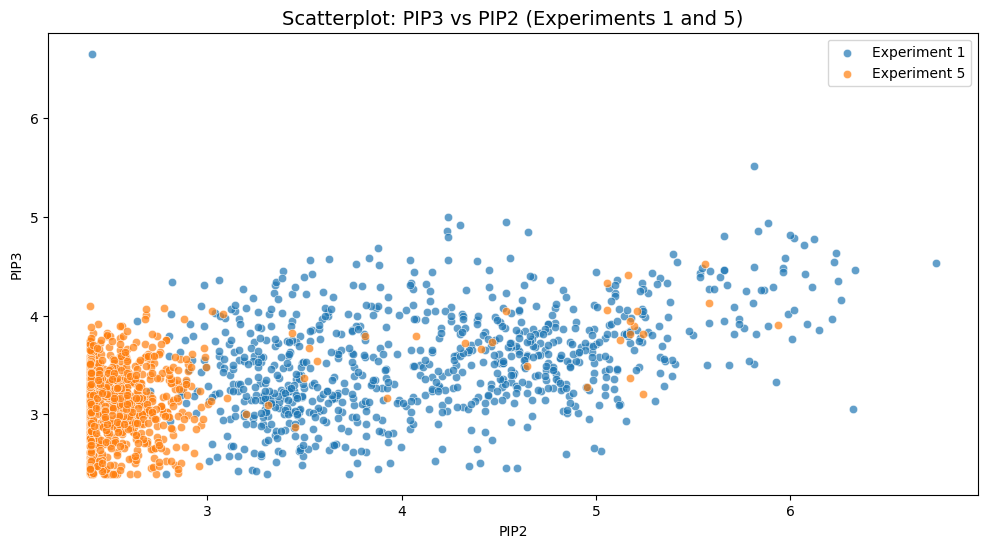

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Separate data for experiments 1 and 5
data_exp1 = experiment_1_and_5[experiment_1_and_5['experiment'] == 1]
data_exp5 = experiment_1_and_5[experiment_1_and_5['experiment'] == 5]

# Scatterplot: PIP2 vs PIP3
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data_exp1, x="PIP2", y="PIP3", label="Experiment 1", alpha=0.7)
sns.scatterplot(data=data_exp5, x="PIP2", y="PIP3", label="Experiment 5", alpha=0.7)
plt.title("Scatterplot: PIP3 vs PIP2 (Experiments 1 and 5)", fontsize=14)
plt.xlabel("PIP2")
plt.ylabel("PIP3")
plt.legend()
plt.show()

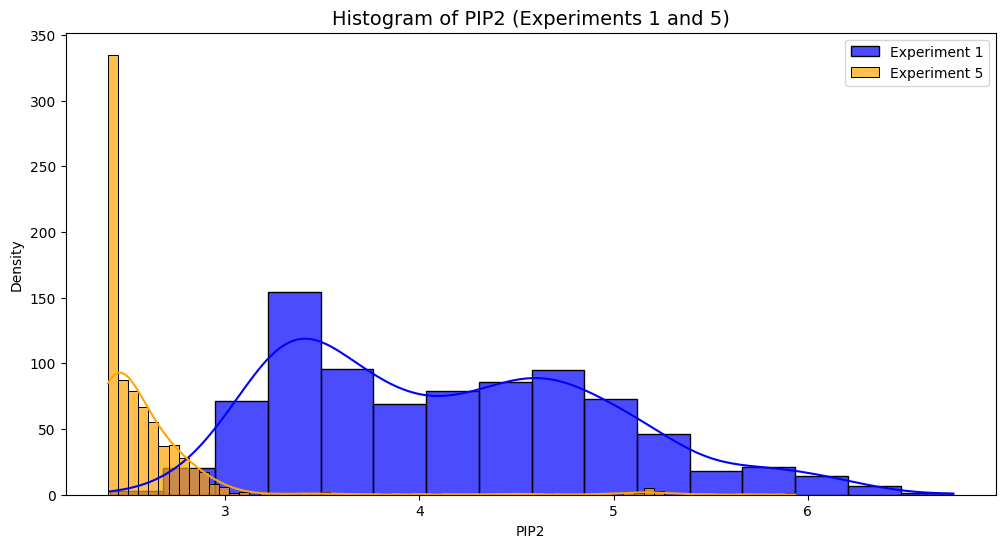

In [ ]:
# Histogram: PIP2
plt.figure(figsize=(12, 6))
sns.histplot(data=data_exp1["PIP2"], kde=True, color="blue", label="Experiment 1", alpha=0.7)
sns.histplot(data=data_exp5["PIP2"], kde=True, color="orange", label="Experiment 5", alpha=0.7)
plt.title("Histogram of PIP2 (Experiments 1 and 5)", fontsize=14)
plt.xlabel("PIP2")
plt.ylabel("Density")
plt.legend()
plt.show()

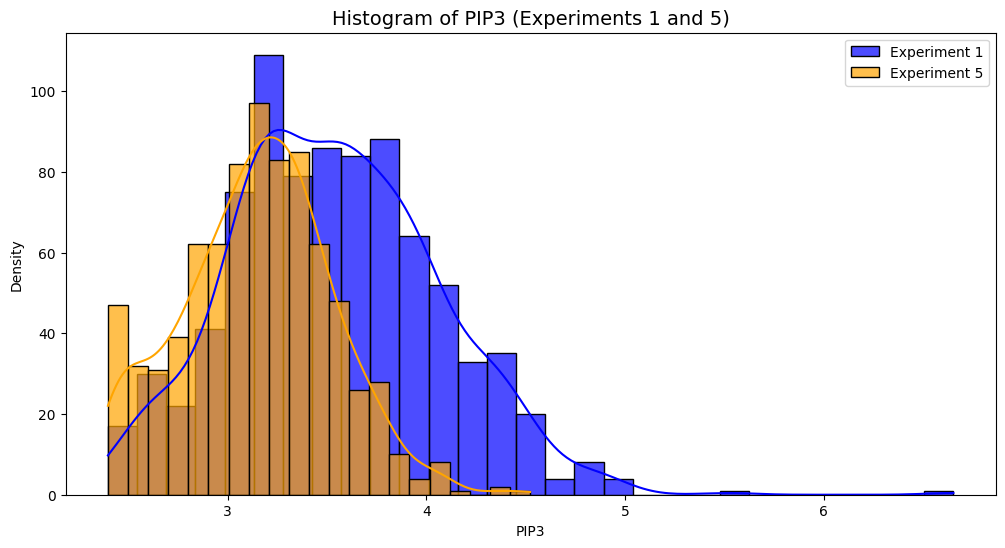

In [ ]:
# Histogram: PIP3
plt.figure(figsize=(12, 6))
sns.histplot(data=data_exp1["PIP3"], kde=True, color="blue", label="Experiment 1", alpha=0.7)
sns.histplot(data=data_exp5["PIP3"], kde=True, color="orange", label="Experiment 5", alpha=0.7)
plt.title("Histogram of PIP3 (Experiments 1 and 5)", fontsize=14)
plt.xlabel("PIP3")
plt.ylabel("Density")
plt.legend()
plt.show()

**Hypotheses:**
- Psitectorigenin directly modifies PIP2.
- Psitectorigenin directly modifies PIP3 (neighbouring variable of PIP2).
- Psitectorigenin directly modifies both PIP2 and PIP3.

To determine whether psitectorigenin has a direct effect on PIP2, PIP3, or both, and to infer the likely direction of causality from the provided plots, we can use the following approach:

**Scatterplots:**

The scatterplot of PIP2 vs. PIP3 for experiments 1 and 5 shows that the data points from experiment 5 (where psitectorigenin was introduced) exhibit a significant shift in PIP2 values while PIP3 also appears to shift slightly.

This pattern suggests that psitectorigenin likely directly affects PIP2 (the primary target), and potentially affects PIP3 indirectly through its relationship with PIP2.


**Histograms:**

The histogram of PIP2 for experiments 1 and 5 shows a strong distinction between the distributions. PIP2 values in experiment 5 cluster in a lower range, indicating a direct modulation by psitectorigenin.

The histogram of PIP3, while showing a shift, is less pronounced, suggesting a weaker direct effect (if any).

**Direction of Causality:**

If PIP2 were upstream of PIP3 in the causal graph, changes in PIP2 due to psitectorigenin would propagate to PIP3. This aligns with the scatterplot showing a stronger alteration in PIP2 compared to PIP3.

Conversely, if PIP3 were upstream, psitectorigenin would need to affect PIP3 first, with the effects on PIP2 secondary. However, the pronounced change in PIP2 argues against this scenario.

**Conclusion:**

From these plots, we assume that psitectorigenin directly modifies PIP2, while its effect on PIP3 is likely mediated through PIP2.

The direction of causality between PIP2 and PIP3 is likely PIP2 → PIP3, based on the data showing a more direct effect on PIP2 in the experimental condition.


# Question 8

**Question 8 (1.5 points)**: In the dataframe for experiments 1 and 6, look at perk, pmek, and any (other) variables adjacent to pmek in the output of PC. Assume it is true that adding U0126 produces an intervention on the *activity* of pmek. What would you expect to see in the data if the graph found by PC was correct? Would you propose any changes to that graph based on the data?

Again put your answer (about 200 words) with accompanying plots in new boxes below here.

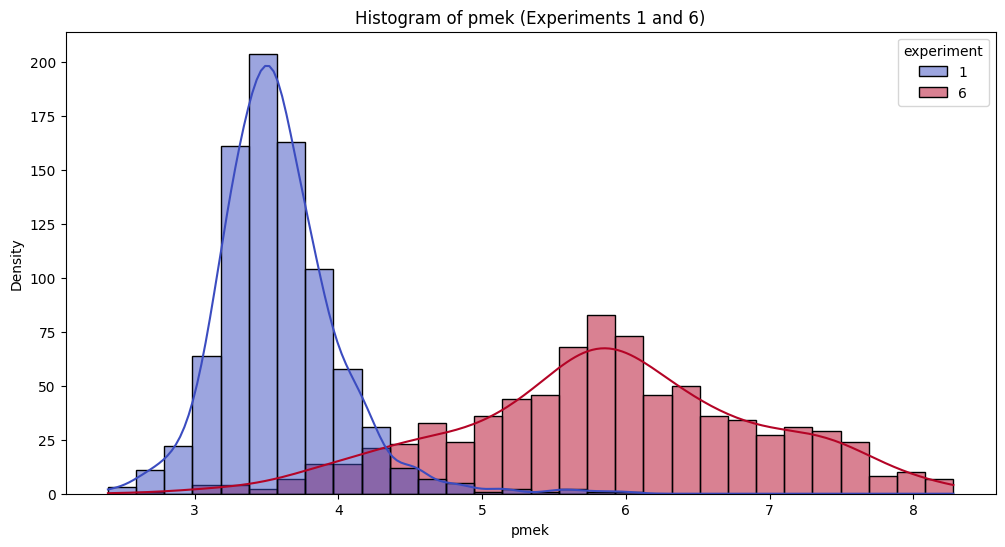

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for experiments 1 and 6
experiment_1_and_6 = all_data[all_data['experiment'].isin([1, 6])]

# Compare distributions of pmek and perk using histograms
plt.figure(figsize=(12, 6))
sns.histplot(data=experiment_1_and_6, x='pmek', hue='experiment', kde=True, palette='coolwarm', bins=30)
plt.title("Histogram of pmek (Experiments 1 and 6)")
plt.xlabel("pmek")
plt.ylabel("Density")
plt.show()

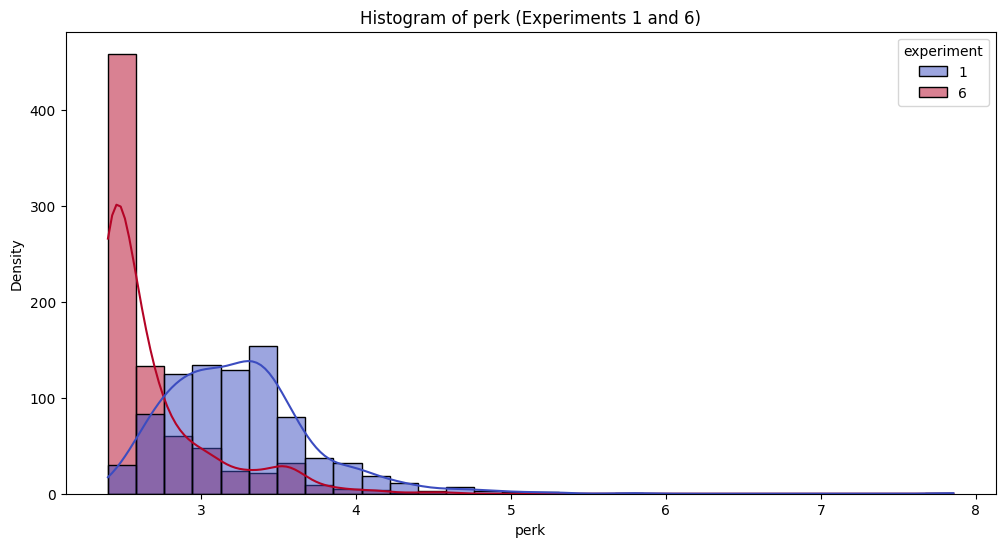

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=experiment_1_and_6, x='perk', hue='experiment', kde=True, palette='coolwarm', bins=30)
plt.title("Histogram of perk (Experiments 1 and 6)")
plt.xlabel("perk")
plt.ylabel("Density")
plt.show()

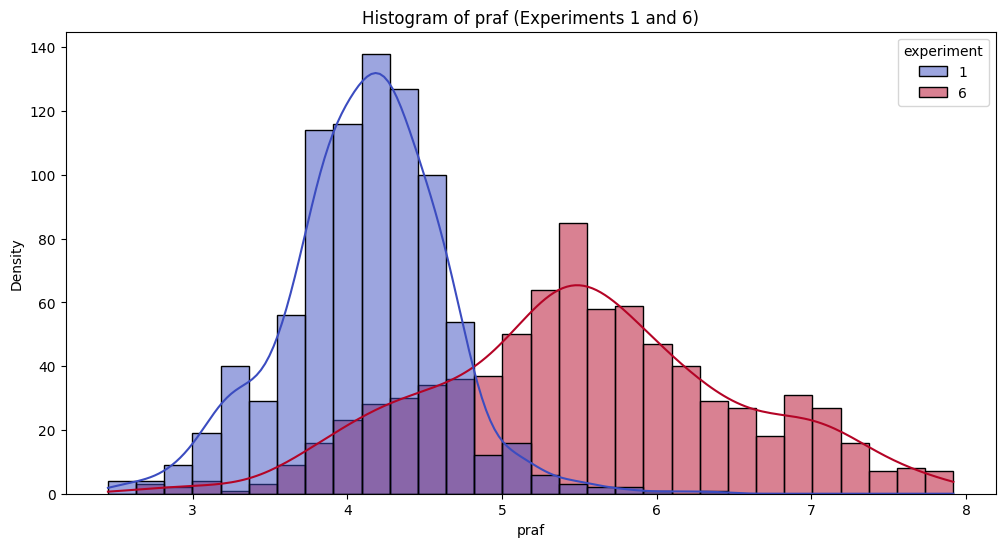

In [ ]:
# Investigate other variables adjacent to pmek (based on PC output)
adjacent_variable = 'praf'  # Example variable that could be adjacent based on PC output
plt.figure(figsize=(12, 6))
sns.histplot(data=experiment_1_and_6, x=adjacent_variable, hue='experiment', kde=True, palette='coolwarm', bins=30)
plt.title(f"Histogram of {adjacent_variable} (Experiments 1 and 6)")
plt.xlabel(adjacent_variable)
plt.ylabel("Density")
plt.show()

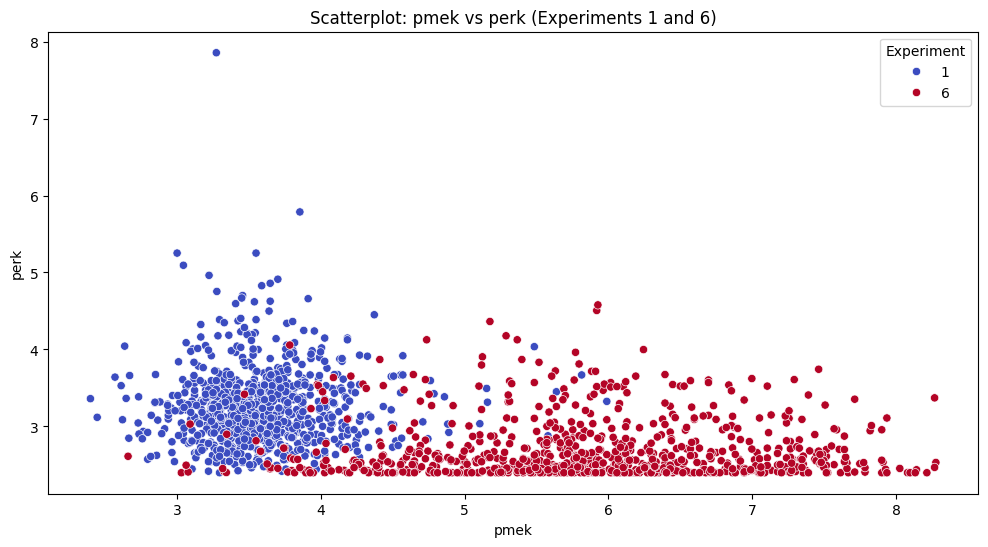

In [ ]:
# Scatterplot of pmek vs perk
plt.figure(figsize=(12, 6))
sns.scatterplot(data=experiment_1_and_6, x='pmek', y='perk', hue='experiment', palette='coolwarm')
plt.title("Scatterplot: pmek vs perk (Experiments 1 and 6)")
plt.xlabel("pmek")
plt.ylabel("perk")
plt.legend(title="Experiment")
plt.show()

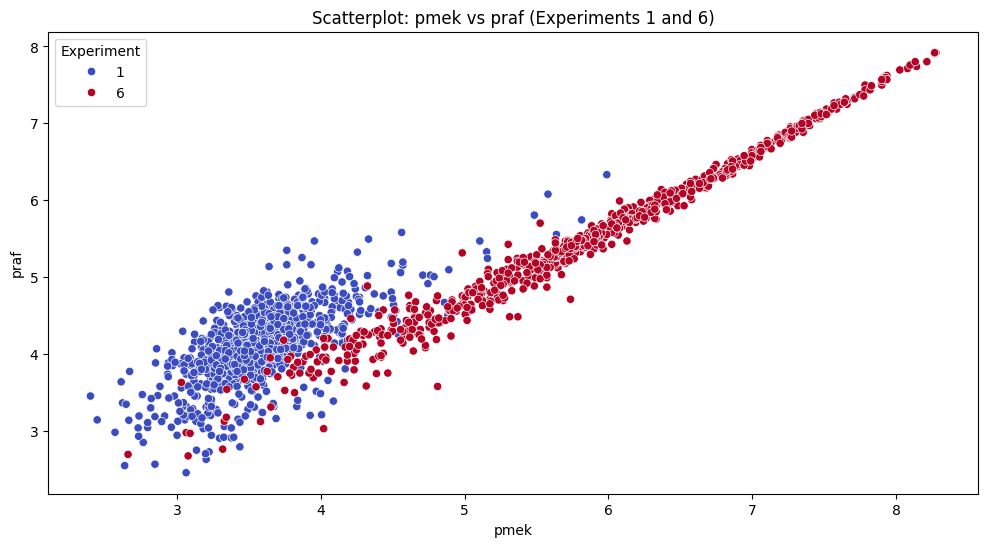

In [ ]:
# Scatterplot of pmek vs perk
plt.figure(figsize=(12, 6))
sns.scatterplot(data=experiment_1_and_6, x='pmek', y='praf', hue='experiment', palette='coolwarm')
plt.title("Scatterplot: pmek vs praf (Experiments 1 and 6)")
plt.xlabel("pmek")
plt.ylabel("praf")
plt.legend(title="Experiment")
plt.show()

Assuming that adding U0126 produces an intervention on the activity of pmek and considering the nodes praf (adjacent to pmek in the PC graph) and perk (not adjacent to pmek in the PC graph), the following should be expected based on the PC graph:
- Praf values should be shifted, since perk is adjacent to pmek in the graph.
- Perk values should not reflect the intervention since there's no direct causal relationship between pmek and perk in the PC graph.

**Plots and suggested changes to PC graph**

Based on the histogram, pmek shows an increasing activity and a shift to the right in experiment 6, when U0126 was added. Similar behavior is expected to be observed at praf's values graph since praf is adjacent to pmek in the PC graph.

Indeed, praf shows a similar behavior in its histogram, with an increase in activity and a shift to the right. This reflects a causal relationship between them as shown in the PC graph. In experiment 6, pmek and praf show a stronger linear relationship compared to experiment 1, as seen in the scatter plot.

The change of pmek's activity is stronger than the change in praf's activity, which suggests that pmek is upstream of praf (pmek → praf), meaning that in experiment 6, U0126 increases pmek's activity and then pmek increases praf's activity. This strongly supports the hypothesis that pmek → praf, where pmek influences praf directly and it should probably be added to the PC graph.

On the other hand, perk shows a decrease in values in experiment 6 even though it's not adjacent to pmek, therefore not likely dependent on pmek and its intervention. The histogram shows a decrease in perk's activity, a shifting to the left and reduction of the width, during experiment 6. This shows that there is a connection between pmek and perk, which is not shown in the PC graph.

The relation between pmek and perk is probably pmek → perk due to the observed behavior in experiment 6, where the intervention targeting pmek (via U0126) leads to a marked reduction in perk values and it should probably be added to the PC graph.

**Conclusion:**

The histograms and the scatterplot related to pmek and praf reflect the relation between them as shown in the PC graph. They also suggest that praf is downstream of pmek in the causal pathway (pmek → praf), which should be added in the PC graph.

The histograms and the scatterplot related to pmek and perk reflect a relation that is not shown in the PC graph and pmek → perk should likely be added in the PC graph.

---

You are almost done! Before handing in, make sure that the code you hand in works, and that all plots are shown. **Submit just one file per team.** Name the submitted file according to your and your collaborator's last name (`submitter_collaborator.ipynb`).

### References
* J. M. Mooij, S. Magliacane, and T. Claassen, "Joint Causal Inference from Multiple Contexts," [JMLR 21(99):1−108](https://jmlr.org/papers/v21/17-123.html), 2020.
* J. Runge, "Conditional Independence Testing Based on a Nearest-Neighbor Estimator of Conditional Mutual Information" In Proceedings of the 21st International Conference on Artificial Intelligence and Statistics, http://proceedings.mlr.press/v84/runge18a.html, 2018.
* K. Sachs, O. Perez, D. Pe’er, D. A. Lauffenburger, and G. P. Nolan, "Causal protein-signaling networks derived from multiparameter single-cell data," Science, vol. 308, no. 5721, pp. 523–529, 2005.